In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))
print(matplotlib.get_backend())

# выбираем девайс для игры
# device = torch.device('cuda:%d' % 3)
# print("Device : {}".format(device))
# torch.cuda.set_device(3)
device = torch.device('cpu')
print(device)

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
module://ipykernel.pylab.backend_inline
cpu
Number of actions : 4


/Users/aapiskotin/anaconda3/envs/python3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 50000


In [4]:
# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.


class StateHolder:
    
    def __init__(self):
        super(StateHolder, self).__init__()
        self.state = torch.zeros(1,STATE_SIZE,STATE_W,STATE_H)
        self.state = self.state.to(device).byte()      


        
    def get(self):
        return self.state
    
    def push(self, batch):
        self.state = self.state.to(device).byte()        
        self.state = torch.squeeze(self.state)
        self.state = self.state[1::]
        self.state = torch.cat((self.state,batch),0)
        self.state = torch.unsqueeze(self.state,0)
        

        
    def reset(self):
        self.state = torch.zeros(1,STATE_SIZE,STATE_W,STATE_H)
        self.state = self.state.to(device).byte()         



# class StateHolder: 
#     def __init__(self): 
#         self.stack=0 
#         self.tmp = [] 
#         self.len=0 

#     def push(self, screen): 
#         if(self.len==0): 
#             self.tmp = [screen]*4 
#             self.stack=torch.stack(self.tmp,1) 
#             self.len = 1 
#         else: 
#             self.tmp.append(screen) 
#             self.stack=torch.stack(self.tmp[-4:],1) 


#     def get(self): 
#         return self.stack.to(device).byte() 

#     def reset(self): 
#         self.stack=0 
#         self.tmp = [] 
#         self.len=0
    
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!
class DQN(nn.Module):
        def __init__(self):
            super(DQN, self).__init__()
            self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
#             self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
#             self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
#             self.bn3 = nn.BatchNorm2d(64)
            self.head = nn.Linear(3136, 512)
            self.head2 = nn.Linear(512,4)
            self.relu = nn.LeakyReLU()
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)
                    m.bias.data.zero_()

        def forward(self, x):
            x = x.float()
            x = self.relu(self.conv1(x))
            #x = F.relu(self.conv1(x))
            x = self.relu(self.conv2(x))
            #x = F.relu(self.conv2(x))
            x = self.relu(self.conv3(x))
            #x = F.relu(self.conv3(x))
            return self.head2(self.head(x.view(x.size(0), -1)))

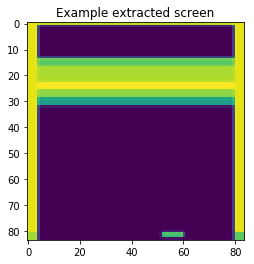

In [6]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device)#.detach()

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [7]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

memory = ReplayMemory()
state_holder = StateHolder()

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [8]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

In [9]:
# количество эпизодов, которые играем
NUM_EPISODES = 100000
TEST_EPS = 0.05
# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE=10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000

policy_net.train()
target_net.eval()

state_holder = StateHolder()
test_rewards = []

# Общее число 
steps_done = 0
eps = EPS_START

  0%|          | 0/100000 [00:00<?, ?it/s]

1 0


  0%|          | 1/100000 [00:00<14:37:08,  1.90it/s]

Episode score : 0.0
Mean score : 0.0
0.9998506123995139 167


  0%|          | 2/100000 [00:01<15:09:24,  1.83it/s]

Episode score : 0.0
Mean score : 0.0
0.9996922526278003 343


  0%|          | 3/100000 [00:01<16:27:27,  1.69it/s]

Episode score : 1.0
Mean score : 0.3333333333333333
0.9994988395861323 558


KeyboardInterrupt: 

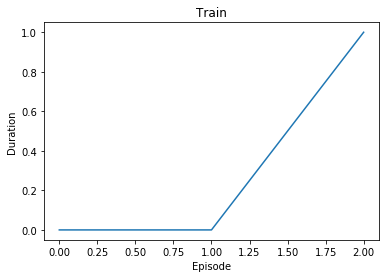

In [11]:

# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm.tqdm(range(NUM_EPISODES)):
    
    # Инициализации разлинычх переменных
    # env - среды
    # state_holder - хранителя состояния
    # lives - количества жизней в начале эпизода игры (Важно!)
    env.reset()
    state_holder.reset()
    state_holder.push(get_screen())
    state = state_holder.get()
    lives = 5    
    ep_rewards = []
    print(eps, steps_done)
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        eps = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        # Шаг одного кадра игры 
        action = select_action(state, eps)
        _, reward, done, info = env.step(action.item())
        ep_rewards.append(reward)
        reward = torch.tensor([reward], device = device)

        
        
        if not done:
            state_holder.push(get_screen())
            next_state = state_holder.get()            
            if info['ale.lives']!= lives:
                lives = info['ale.lives']
                memory.push(state,action , None, reward)
            else:
                memory.push(state,action , next_state, reward)
        else:
            next_state=None
            memory.push(state,action , next_state, reward)
            
        steps_done += 1
        state = next_state
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        # info - важная системная информация
        
        # Код обработки перехода
        # Работа с ReplayMemory

    
        
        # Задание 3.1. Необходимо дополниь код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тет самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод
            print("Episode score : {}".format(train_rewards[-1]))
            # Средний reward по последним 100 эпизодам
            print("Mean score : {}".format(np.mean(train_rewards[-100:])))
            
            plot_rewards()
            break 


            
            
            





In [10]:
policy_net = DQN()
policy_net.load_state_dict(torch.load("./weights.txt", map_location=device))

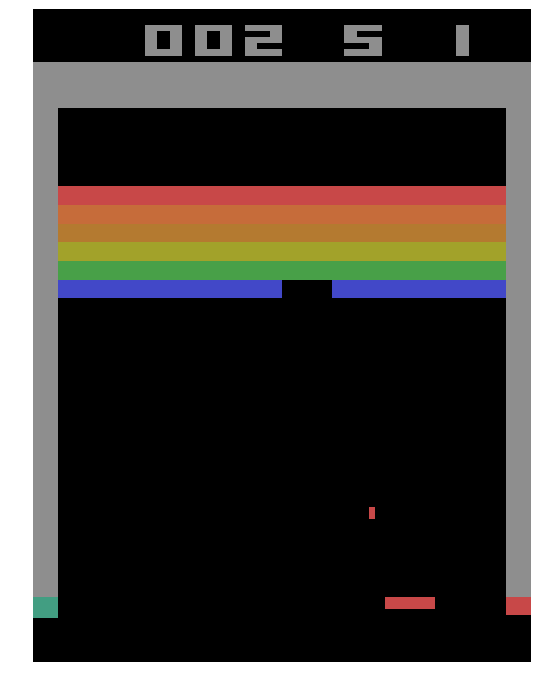

In [ ]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(figsize=(12, 12))
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
#     plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def select_action(state,eps_threshold):
    global steps_done
    eps_threshold = TEST_EPS
    
    steps_done += 1
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        env.reset()
        state_holder.reset()
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))

In [14]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(policy_net, f)
with open('data2.pickle', 'wb') as f:
    pickle.dump(target_net, f)

In [11]:
policy_net.save_weights("policy_model.h5")

AttributeError: 'DQN' object has no attribute 'save_weights'

In [16]:
import json
json = policy_net.toJSON()

AttributeError: 'DQN' object has no attribute 'toJSON'

In [19]:
torch.save(policy_net, './policy')

/home/a.oleshko/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
torch.save(policy_net.state_dict(), './weights')